<font size="6"> **Model Building: Linear Models** </font>

In [1]:
%%capture
%run 00_mlmod_load_data.ipynb

In [2]:
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

import pickle

In [3]:
OUTPATH = os.path.join(io_utils.processed_path , cfg['output']['alpha_factors_ml']['folder'], MODEL_VERSION, "")

OUTFILE1 = cfg['output']['alpha_factors_ml']['preds']
print(os.path.isdir(OUTPATH))

True


In [4]:
MODEL_PATH = os.path.join(io_utils.models_path , cfg['output']['alpha_factors_ml']['folder'], MODEL_VERSION, "")

MODEL_NAME = cfg['output']['alpha_factors_ml']['model']
MODEL_METADATA = cfg['output']['alpha_factors_ml']['model_metadata']
print(os.path.isdir(MODEL_PATH))

True


In [5]:
# Overwrite persisted versions of sampled data
X_train_smp = pd.read_csv(io_utils.interim_path + 'x_train_smp.csv', parse_dates=['date'], index_col=[0,1])
y_train_smp = pd.read_csv(io_utils.interim_path + 'y_train_smp.csv', parse_dates=['date'], index_col=[0,1])
y_train_smp = y_train_smp[target_col]

In [6]:
(y_train_smp>0).value_counts()

True     24038
False    18957
Name: target, dtype: int64

# Model Benchmarking

In [7]:
benchmark_path = os.path.join(io_utils.interim_path, f"benchmark_{MODEL_VERSION}", "")

ridge_sum_join_df = pd.read_csv(benchmark_path + "ridge_benchmark.csv", index_col='rank_test_w_accuracy')
ridge_metrics_cvdet = pd.read_csv(benchmark_path + "ridge_smp_cvdet.csv", index_col='rank_test_w_accuracy')
ridge_full_metrics_cvdet = pd.read_csv(benchmark_path + "ridge_full_cvdet.csv", index_col='rank_test_w_accuracy')
ridge_nov_metrics_cvdet = pd.read_csv(benchmark_path + "ridge_nov_cvdet.csv", index_col='rank_test_w_accuracy')

rf_sum_join_df = pd.read_csv(benchmark_path + "rf_benchmark.csv", index_col='rank_test_w_accuracy')
rf_metrics_cvdet = pd.read_csv(benchmark_path + "rf_smp_cvdet.csv", index_col='rank_test_w_accuracy')
rf_full_metrics_cvdet = pd.read_csv(benchmark_path + "rf_full_cvdet.csv", index_col='rank_test_w_accuracy')
rf_nov_metrics_cvdet = pd.read_csv(benchmark_path + "rf_nov_cvdet.csv", index_col='rank_test_w_accuracy')

In [8]:
summary_join_df = ridge_sum_join_df.join(
    rf_sum_join_df, lsuffix='_ridge', rsuffix='_rf')

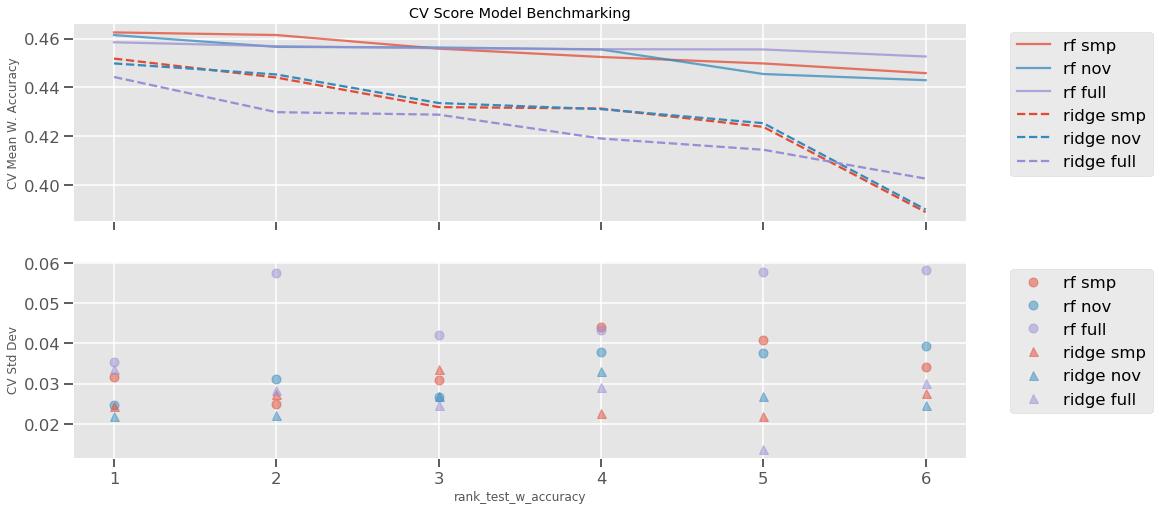

In [9]:
fig, axs = plt.subplots(2,1, sharex=True)

means = summary_join_df.filter(regex='^mean_').sort_index()
stdevs = summary_join_df.filter(regex='^std_')

labels = [" ".join(x.split("_")[-2:][::-1]) for x in means.columns]
labels_rf = [x for x in labels if x.startswith('rf')]
labels_ridge = [x for x in labels if x.startswith('ridge')]

ax = axs[0]
means.filter(regex='_rf$').plot(
    ax = ax,  alpha=0.75)
color_lst = [x.get_color() for x in ax.get_lines()]

means.filter(regex='_ridge$').plot(
    ax = ax, linestyle='--', color=color_lst)

ax.legend(labels = labels_rf + labels_ridge, bbox_to_anchor=(1.04, 1), loc='upper left')
ax.set_ylabel('CV Mean W. Accuracy')
ax.set_title('CV Score Model Benchmarking')


ax = axs[1]
stdevs.filter(regex='_rf$').plot(
    ax = ax, linewidth=0, marker='o', color=color_lst, alpha=0.5)
color_lst = [x.get_color() for x in ax.get_lines()]

stdevs.filter(regex='_ridge$').plot(
    ax = ax, linewidth=0, marker='^', color=color_lst, alpha=0.5)

ax.legend(labels = labels_rf + labels_ridge, bbox_to_anchor=(1.04, 1), loc='upper left')
ax.set_ylabel('CV Std Dev')


plt.show()

## Ridge Models

In [10]:
ridge_params = ['alpha']
ridge_sum_join_top_df = ridge_sum_join_df.sort_values(by='rank_test_w_accuracy').head(10)
ridge_sum_join_top_df

,alpha_smp,std_test_w_accuracy_smp,mean_test_w_accuracy_smp,alpha_nov,std_test_w_accuracy_nov,mean_test_w_accuracy_nov,alpha_full,std_test_w_accuracy_full,mean_test_w_accuracy_full
rank_test_w_accuracy,,,,,,,,,
1,0.100,0.024459,0.451821,0.100,0.021889,0.449837,0.100,0.033731,0.444278
2,0.010,0.027500,0.444042,0.010,0.022066,0.445307,10.000,0.028305,0.429833
3,0.001,0.033595,0.431918,1.000,0.026876,0.433587,1.000,0.024552,0.428803
4,1.000,0.022685,0.431320,0.001,0.033238,0.431077,0.010,0.029162,0.419020
5,10.000,0.021912,0.423781,10.000,0.026837,0.425309,100.000,0.013657,0.414397
6,100.000,0.027776,0.388810,100.000,0.024546,0.389882,0.001,0.030028,0.402553


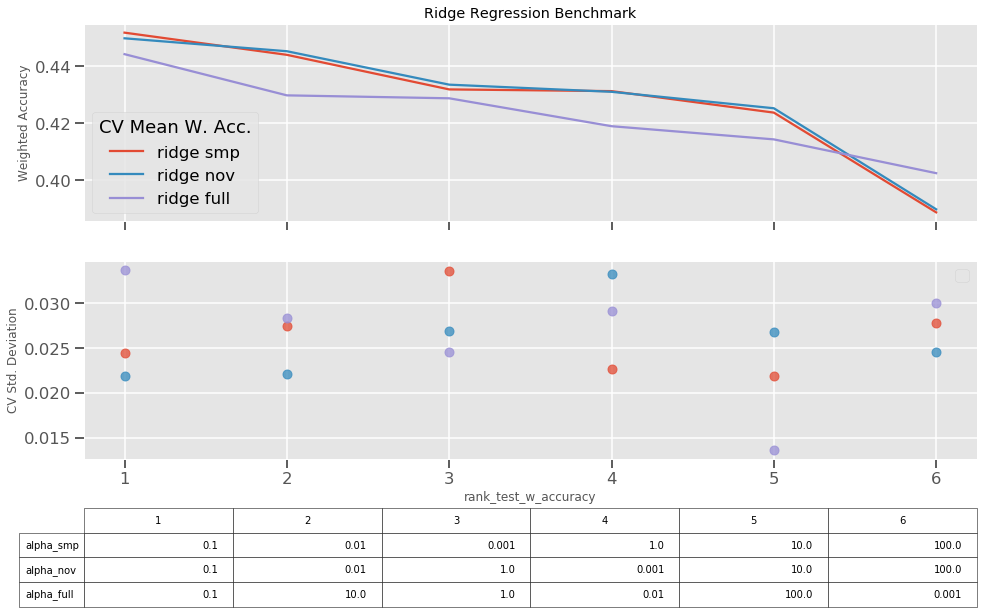

In [11]:
fig, axs = plt.subplots(2,1, sharex=True)

ax =  axs[0]
ridge_sum_join_top_df.filter(regex='^mean_').plot(ax=ax, label=['sample', 'sample no weekday (nov)', 'full'])
ax.legend(labels=labels_ridge, title='CV Mean W. Acc.')
ax.set_ylabel('Weighted Accuracy')
ax.set_title("Ridge Regression Benchmark")

ax =  axs[1]
ax = ridge_sum_join_top_df.filter(regex='^std_').plot(ax=ax, style='o', alpha=0.75)
ax.legend("")
ax.set_ylabel('CV Std. Deviation')


ridge_params_cols = [x for x in ridge_sum_join_top_df.columns if x[:x.rfind("_")] in ridge_params]
colors = [[ax.get_lines()[i].get_color()]*len(ridge_params) for i in range(0,3)]

ridge_benchmark_tb = plt.table(cellText=ridge_sum_join_top_df[ridge_params_cols].T.astype(str).values,
                      rowLabels=ridge_params_cols,
                      colLabels=ridge_sum_join_top_df.index,
                      loc='bottom',bbox=[0., -.75, 1., .5])#[left, bottom, width , height]

ridge_benchmark_tb.auto_set_font_size(True)


plt.show()

## Selected Ridge Model

In [12]:
champ_ridge_rank = 2
champ_ridge_score = ridge_metrics_cvdet.loc[champ_ridge_rank,'mean_test_w_accuracy']
champ_ridge_alpharank = ridge_metrics_cvdet.loc[champ_ridge_rank, 'alpha']
top_ridge_score = ridge_metrics_cvdet.loc[1, 'mean_test_w_accuracy']
top_ridge_alpharank = ridge_metrics_cvdet.loc[1, 'alpha']
champ_ridge_score, champ_ridge_alpharank, top_ridge_score, top_ridge_alpharank

(0.4440424279924371, 0.01, 0.4518205028632451, 0.1)

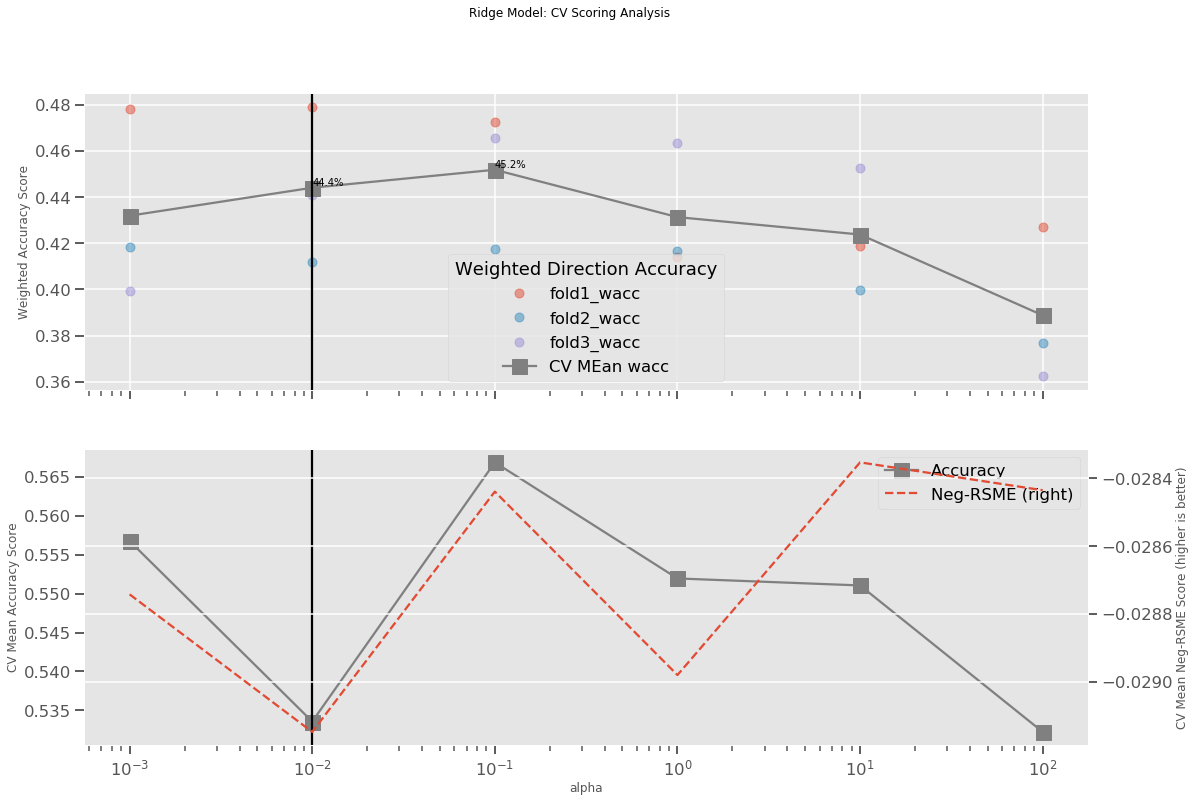

In [13]:
fig, axs = plt.subplots(2,1, sharex=True, figsize=(18,12))

plt.suptitle("Ridge Model: CV Scoring Analysis")
ax = axs[0]
ridge_metrics_cvdet.plot(ax=ax, x='alpha', y=['split0_test_w_accuracy','split1_test_w_accuracy', 'split2_test_w_accuracy'],
                        logx=True, style='o', alpha=0.5, label=['fold1_wacc', 'fold2_wacc', 'fold3_wacc'])
ridge_metrics_cvdet.plot(ax=ax, x='alpha', y='mean_test_w_accuracy',
                        logx=True, marker='s', markersize=15, color='grey', label='CV MEan wacc')
ax.legend(title="Weighted Direction Accuracy")
ax.set_ylabel('Weighted Accuracy Score')
ax.text(top_ridge_alpharank, top_ridge_score, f'{top_ridge_score:0.1%}', va='bottom', ha='left')
ax.text(champ_ridge_alpharank, champ_ridge_score, f'{champ_ridge_score:0.1%}', va='bottom', ha='left')

ax = axs[1]
ridge_metrics_cvdet.plot(ax=ax, x='alpha', y='mean_test_accuracy',
                         label='Accuracy',color='grey',
                        logx=True,marker='s', markersize=15)
plt.ylabel('CV Mean Accuracy Score')

ridge_metrics_cvdet.plot(ax=ax, x='alpha', y='mean_test_neg_root_mean_squared_error',
                         secondary_y=True,
                         label='Neg-RSME',
                         linestyle='--',
                        logx=True)

plt.ylabel('CV Mean Neg-RSME Score (higher is better)')

for ax in axs:
    ax.axvline(x=champ_ridge_alpharank, color='black')
    
plt.show()


## Random Forest Model

In [14]:
rf_params = ['max_samples', 'max_features', 'min_samples_leaf']

rf_sum_join_top_df = rf_sum_join_df.sort_values(by='rank_test_w_accuracy').head(10)
rf_sum_join_top_df

,max_samples_smp,max_features_smp,min_samples_leaf_smp,std_test_w_accuracy_smp,mean_test_w_accuracy_smp,max_samples_nov,max_features_nov,min_samples_leaf_nov,std_test_w_accuracy_nov,mean_test_w_accuracy_nov,max_samples_full,max_features_full,min_samples_leaf_full,std_test_w_accuracy_full,mean_test_w_accuracy_full
rank_test_w_accuracy,,,,,,,,,,,,,,,
1,0.75,0.75,250,0.031751,0.462570,0.75,0.75,250,0.024643,0.461483,0.75,0.75,1000,0.035355,0.458522
2,0.50,0.75,250,0.024945,0.461497,0.50,0.75,1000,0.031087,0.456632,0.25,0.75,500,0.057469,0.456913
3,0.50,0.75,1000,0.030793,0.455906,0.50,0.75,250,0.026603,0.456378,0.50,0.75,1000,0.042143,0.456081
4,0.75,0.50,250,0.044123,0.452483,0.75,0.50,250,0.037850,0.455557,0.50,0.75,2500,0.043187,0.455672
5,0.75,0.75,500,0.040887,0.449820,0.75,0.25,250,0.037708,0.445487,0.50,0.50,1000,0.057821,0.455576
6,0.75,0.50,500,0.034167,0.445844,0.50,0.50,250,0.039341,0.442961,0.75,0.50,1000,0.058317,0.452673
7,0.50,0.50,250,0.039756,0.443784,0.75,0.75,500,0.036000,0.442935,0.25,0.50,500,0.055245,0.448710
8,0.75,0.25,250,0.023681,0.441298,0.50,0.25,250,0.028248,0.431932,0.50,0.50,500,0.049533,0.445562
9,0.50,0.25,250,0.025593,0.434066,0.50,0.50,2500,0.054533,0.427111,0.25,0.75,1000,0.048694,0.444863


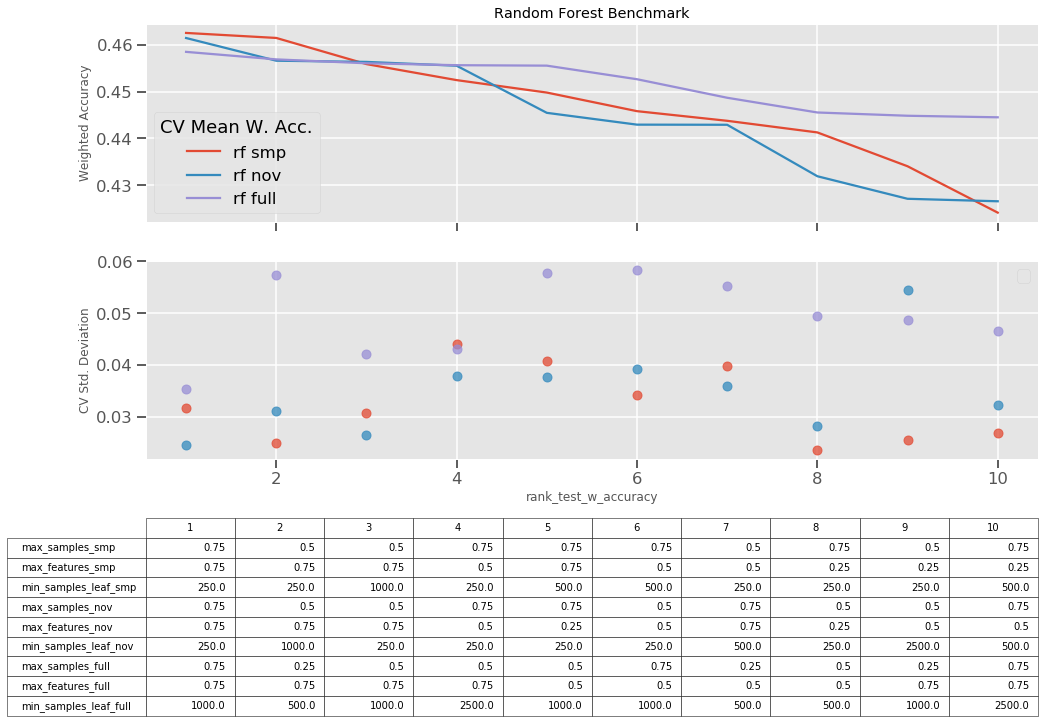

In [15]:
fig, axs = plt.subplots(2,1, sharex=True)

ax =  axs[0]
rf_sum_join_top_df.filter(regex='^mean_').plot(ax=ax, label=['sample', 'sample no weekday (nov)', 'full'])
ax.legend(labels=labels_rf, title='CV Mean W. Acc.')
ax.set_ylabel('Weighted Accuracy')
ax.set_title("Random Forest Benchmark")

ax =  axs[1]
ax = rf_sum_join_top_df.filter(regex='^std_').plot(ax=ax, style='o', alpha=0.75)
ax.legend("")
ax.set_ylabel('CV Std. Deviation')


rf_params_cols = [x for x in rf_sum_join_top_df.columns if x[:x.rfind("_")] in rf_params]
colors = [[ax.get_lines()[i].get_color()]*len(rf_params) for i in range(0,3)]

rf_benchmark_tb = plt.table(cellText=rf_sum_join_top_df[rf_params_cols].T.astype(str).values,
                      rowLabels=rf_params_cols,
                      colLabels=rf_sum_join_top_df.index,
                      loc='bottom',bbox=[0., -1.3, 1., 1.])#[left, bottom, width , height]

rf_benchmark_tb.auto_set_font_size(True)


plt.show()

## Selected Random Forest Model

In [16]:
champ_rf_rank = 1
champ_rf_score = rf_full_metrics_cvdet.loc[champ_rf_rank,'mean_test_w_accuracy']

top_rf_score = rf_full_metrics_cvdet.loc[1, 'mean_test_w_accuracy']
champ_rf_score, champ_rf_rank, top_rf_score

(0.4585216214366733, 1, 0.4585216214366733)

In [17]:
rf_metrics_cvdet_top = rf_full_metrics_cvdet.reset_index().sort_values(by='rank_test_w_accuracy').head(10)
hparams_tb = rf_metrics_cvdet_top.pivot_table(index='rank_test_w_accuracy', values=['max_features', 'max_samples', 'min_samples_leaf']).T

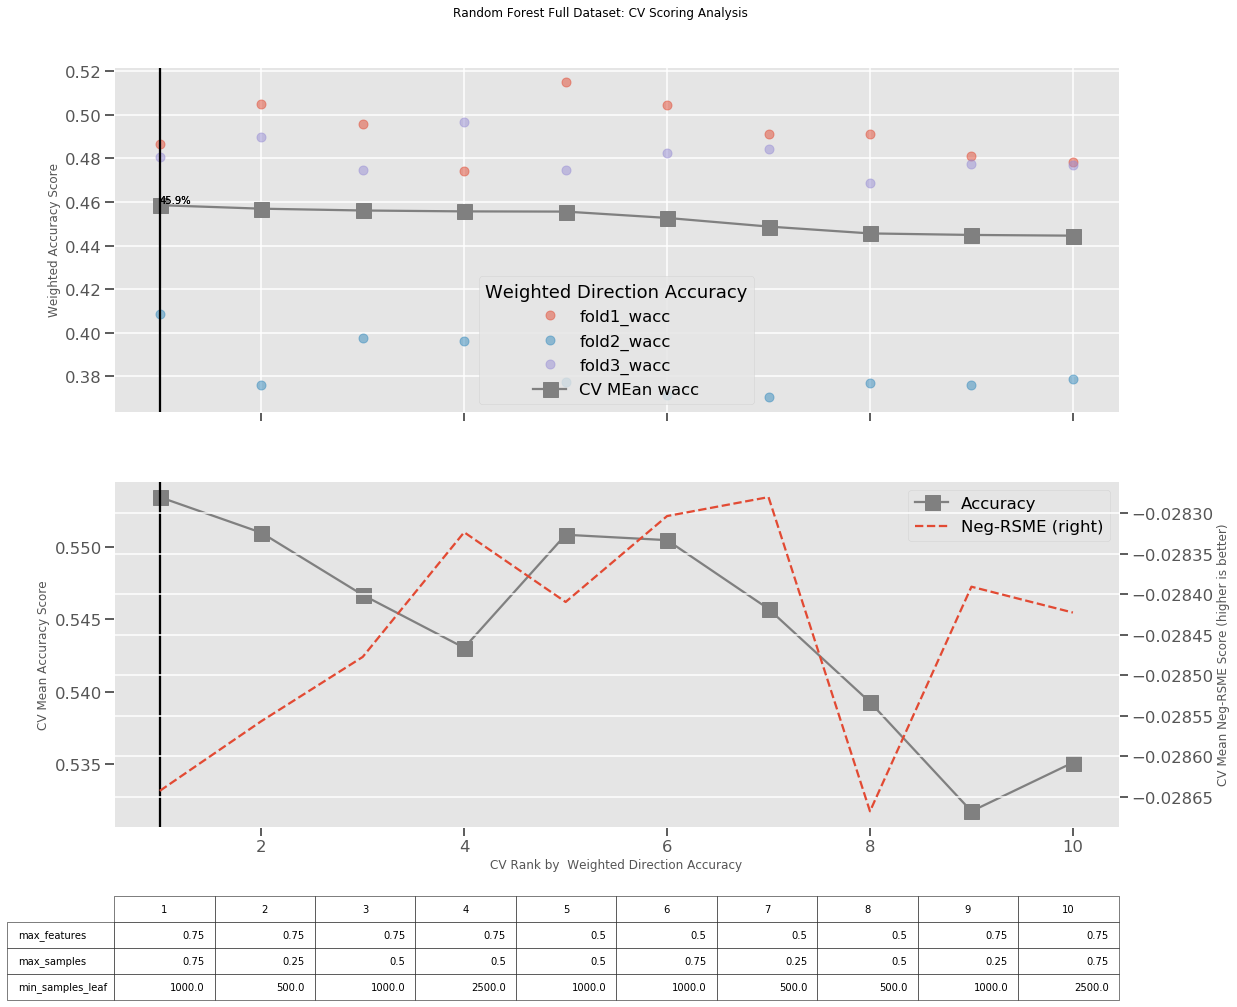

In [18]:
fig, axs = plt.subplots(2,1, sharex=True, figsize=(18,12))

plt.suptitle("Random Forest Full Dataset: CV Scoring Analysis", y=0.95)
ax = axs[0]
rf_metrics_cvdet_top.plot(ax=ax, x='rank_test_w_accuracy', y=['split0_test_w_accuracy','split1_test_w_accuracy', 'split2_test_w_accuracy'],
                        style='o', alpha=0.5, label=['fold1_wacc', 'fold2_wacc', 'fold3_wacc'])
rf_metrics_cvdet_top.plot(ax=ax, x='rank_test_w_accuracy', y='mean_test_w_accuracy',
                        marker='s', markersize=15, color='grey', label='CV MEan wacc')
ax.legend(title="Weighted Direction Accuracy")
ax.set_ylabel('Weighted Accuracy Score')
ax.text(1, top_rf_score, f'{top_rf_score:.1%}', va='bottom', ha='left')
ax.text(champ_rf_rank, champ_rf_score, f'{champ_rf_score:.1%}', va='bottom', ha='left')

ax = axs[1]
rf_metrics_cvdet_top.plot(ax=ax, x='rank_test_w_accuracy', y='mean_test_accuracy',
                         label='Accuracy',color='grey',
                        marker='s', markersize=15)
plt.ylabel('CV Mean Accuracy Score')

rf_metrics_cvdet_top.plot(ax=ax, x='rank_test_w_accuracy', y='mean_test_neg_root_mean_squared_error',
                         secondary_y=True,
                         label='Neg-RSME',
                         linestyle='--')

plt.ylabel('CV Mean Neg-RSME Score (higher is better)')
ax.set_xlabel('CV Rank by  Weighted Direction Accuracy')

rf_metrics_cvdet_top_tb = ax.table(cellText=hparams_tb.astype(str).values,
                      rowLabels=hparams_tb.index.tolist(),
                      colLabels=hparams_tb.columns.tolist(),
                      loc='bottom',bbox=[0., -.5, 1., .3])#[left, bottom, width , height]

rf_metrics_cvdet_top_tb.auto_set_font_size(True)

for ax in axs:
    ax.axvline(x=champ_rf_rank, color='black')
plt.subplots_adjust(bottom=0.)


plt.show()


# Experimental: Non Overlap Voters Ensembles

## Ridge

## Experimental Ensemble

In [19]:
hparams_ridge_nov = {'alpha': 1.}

In [20]:
ridge = Ridge(fit_intercept=False, random_state=RND_SEED, **hparams_ridge_nov)

In [21]:
ridge_nov_ensemble = mle_utils.NoOverlapVoterRegressor(base_estimator=ridge, n_skip_samples=4)
ridge_nov_ensemble.fit(X_train_full[features_nov], y_train_full)

NoOverlapVoterRegressor(base_estimator=Ridge(alpha=1.0, copy_X=True,
                                             fit_intercept=False, max_iter=None,
                                             normalize=False, random_state=123,
                                             solver='auto', tol=0.001),
                        n_skip_samples=4)

## Random Forest

In [22]:
hparams_rf_nov = {'max_samples': 0.75,
            'max_features': 0.75,
            'min_samples_leaf': 250}

In [23]:
rf = RandomForestRegressor(n_estimators=200, criterion='mse',
                            bootstrap=True,oob_score=True,
                            n_jobs=-1, random_state=RND_SEED, **hparams_rf_nov)

In [24]:
rf_nov_ensemble = mle_utils.NoOverlapVoterRegressor(base_estimator=rf, n_skip_samples=4)
rf_nov_ensemble.fit(X_train_full[features_nov], y_train_full)

NoOverlapVoterRegressor(base_estimator=RandomForestRegressor(bootstrap=True,
                                                             ccp_alpha=0.0,
                                                             criterion='mse',
                                                             max_depth=None,
                                                             max_features=0.75,
                                                             max_leaf_nodes=None,
                                                             max_samples=0.75,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=250,
                                                             min_samples_split=2,
                                                             min_weight_fraction_leaf=0.0,
                     

# Select Champion Models

## Fit champions on Train

In [25]:
# Select rank and model kind
ridge_select_s = ridge_sum_join_top_df.loc[champ_ridge_rank].filter(regex='_smp$')

ridge_select_s.index = [x[:x.rfind("_")] for x in ridge_select_s.index]
ridge_select_params = ridge_select_s[ridge_params].to_dict()
ridge_select_params

{'alpha': 0.01}

In [26]:
champ_ridge = Ridge(fit_intercept=False, random_state=RND_SEED)
champ_ridge.set_params(**ridge_select_params)
champ_ridge.fit(X_train_smp, y_train_smp)

Ridge(alpha=0.01, copy_X=True, fit_intercept=False, max_iter=None,
      normalize=False, random_state=123, solver='auto', tol=0.001)

In [27]:
# Select rank and model kind
rf_select_s = rf_sum_join_top_df.loc[champ_rf_rank].filter(regex='_full$')

rf_select_s.index = [x[:x.rfind("_")] for x in rf_select_s.index]
rf_select_params = rf_select_s[rf_params].to_dict()
rf_select_params.update({'min_samples_leaf': int(rf_select_s['min_samples_leaf'])})
rf_select_params

{'max_samples': 0.75, 'max_features': 0.75, 'min_samples_leaf': 1000}

In [28]:
champ_rf = RandomForestRegressor(n_estimators=200, criterion='mse',
                            bootstrap=True,oob_score=True,
                            n_jobs=-1, random_state=RND_SEED)
champ_rf.set_params(**rf_select_params)
champ_rf.fit(X_train_full, y_train_full)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.75, max_leaf_nodes=None,
                      max_samples=0.75, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1000,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=-1, oob_score=True,
                      random_state=123, verbose=0, warm_start=False)

## Predictions

In [29]:
p_valid_ridge = pd.Series(index=y_valid_full.index, data=champ_ridge.predict(X_valid_full))
p_valid_rf = pd.Series(index=y_valid_full.index, data=champ_rf.predict(X_valid_full))
p_valid_ridge.name = 'ridge_smpl'
p_valid_rf.name = 'rf_full'

In [30]:
p_valid_ridge_nov = pd.Series(index=y_valid_full.index, data=ridge_nov_ensemble.predict(X_valid_full[features_nov]))
p_valid_rf_nov = pd.Series(index=y_valid_full.index, data=rf_nov_ensemble.predict(X_valid_full[features_nov]))
p_valid_ridge_nov.name = 'ridge_nov_ensemble'
p_valid_rf_nov.name = 'rf_nov_ensemble'

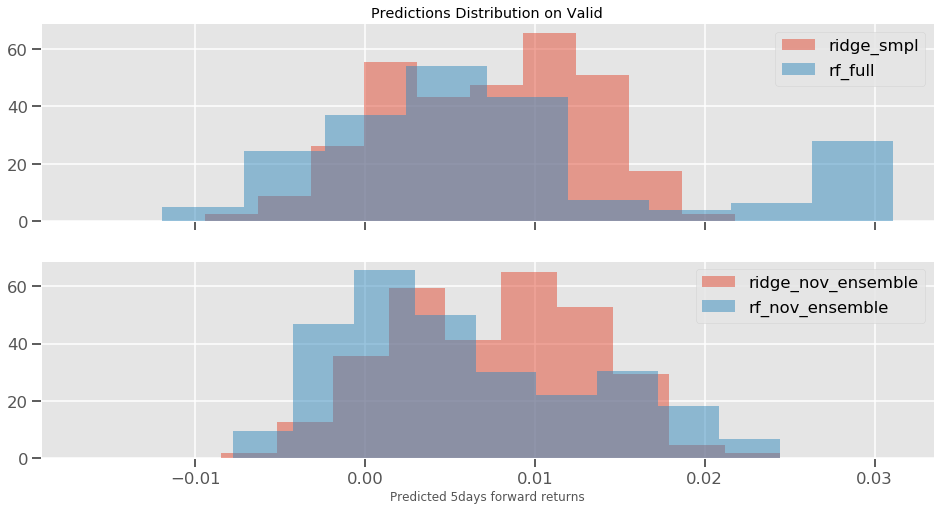

In [31]:
fig, axs = plt.subplots(2,1, sharex=True)

ax = axs[0]
p_valid_ridge.hist(ax=ax, density=True, alpha=0.5, label=p_valid_ridge.name)
p_valid_rf.hist(ax=ax,density=True, alpha=0.5, label=p_valid_rf.name)

ax.set_title('Predictions Distribution on Valid')
ax.legend()

ax = axs[1]
p_valid_ridge_nov.hist(ax=ax, density=True, alpha=0.5, label=p_valid_ridge_nov.name)
p_valid_rf_nov.hist(ax=ax, density=True, alpha=0.5, label=p_valid_rf_nov.name)

ax.set_xlabel('Predicted 5days forward returns')
ax.legend()


plt.show()

## Assess Champions on Valid

In [32]:
valid_perf_df = pd.DataFrame(index=['valid_wacc', 'valid_acc_down', 'valid_acc_up'],
                             columns=['ridge_smp', 'rf_full', 'ridge_nov_ensemble', 'rf_nov_ensemble'], dtype=float)

valid_perf_df.loc['valid_wacc', 'ridge_smp'] = mle_utils.direction_accuracy_func(y_valid_full, p_valid_ridge, kind='weighted', w_fp=2., w_fn=1.)
valid_perf_df.loc['valid_acc_down', 'ridge_smp'] = mle_utils.direction_accuracy_func(y_valid_full, p_valid_ridge, kind='downwards')
valid_perf_df.loc['valid_acc_up', 'ridge_smp'] = mle_utils.direction_accuracy_func(y_valid_full, p_valid_ridge, kind='upwards')

valid_perf_df.loc['valid_wacc', 'rf_full'] = mle_utils.direction_accuracy_func(y_valid_full, p_valid_rf, kind='weighted', w_fp=2., w_fn=1.)
valid_perf_df.loc['valid_acc_down', 'rf_full'] = mle_utils.direction_accuracy_func(y_valid_full, p_valid_rf, kind='downwards')
valid_perf_df.loc['valid_acc_up', 'rf_full'] = mle_utils.direction_accuracy_func(y_valid_full, p_valid_rf, kind='upwards')


valid_perf_df.loc['valid_wacc', 'ridge_nov_ensemble'] = mle_utils.direction_accuracy_func(y_valid_full, p_valid_ridge_nov, kind='weighted', w_fp=2., w_fn=1.)
valid_perf_df.loc['valid_acc_down', 'ridge_nov_ensemble'] = mle_utils.direction_accuracy_func(y_valid_full, p_valid_ridge_nov, kind='downwards')
valid_perf_df.loc['valid_acc_up', 'ridge_nov_ensemble'] = mle_utils.direction_accuracy_func(y_valid_full, p_valid_ridge_nov, kind='upwards')

valid_perf_df.loc['valid_wacc', 'rf_nov_ensemble'] = mle_utils.direction_accuracy_func(y_valid_full, p_valid_rf_nov, kind='weighted', w_fp=2., w_fn=1.)
valid_perf_df.loc['valid_acc_down', 'rf_nov_ensemble'] = mle_utils.direction_accuracy_func(y_valid_full, p_valid_rf_nov, kind='downwards')
valid_perf_df.loc['valid_acc_up', 'rf_nov_ensemble'] = mle_utils.direction_accuracy_func(y_valid_full, p_valid_rf_nov, kind='upwards')


In [33]:
valid_perf_df

,ridge_smp,rf_full,ridge_nov_ensemble,rf_nov_ensemble
valid_wacc,0.403421,0.381678,0.395467,0.395739
valid_acc_down,0.129065,0.192208,0.093136,0.226811
valid_acc_up,0.887537,0.766818,0.906859,0.763178


In [34]:
# Load kind summary report and select rank
ridge_smp_sum_df = pd.read_csv(benchmark_path + "ridge_smp_summary.csv", index_col='rank_test_w_accuracy')

ridge_smp_sum_df.loc[champ_ridge_rank, ['alpha', 'mean_test_w_accuracy', 'mean_test_down_accuracy', 'mean_test_up_accuracy']]

alpha                      0.010000
mean_test_w_accuracy       0.444042
mean_test_down_accuracy    0.539749
mean_test_up_accuracy      0.539325
Name: 2, dtype: float64

In [35]:
# Load kind summary report and select rank
rf_full_sum_df = pd.read_csv(benchmark_path + "rf_full_summary.csv", index_col='rank_test_w_accuracy')

rf_full_sum_df.loc[champ_rf_rank, ['max_features', 'max_samples', 'min_samples_leaf', 'mean_test_w_accuracy', 'mean_test_down_accuracy', 'mean_test_up_accuracy']]


max_features                  0.750000
max_samples                   0.750000
min_samples_leaf           1000.000000
mean_test_w_accuracy          0.458522
mean_test_down_accuracy       0.519053
mean_test_up_accuracy         0.575941
Name: 1, dtype: float64

# Refit Champion Model on Train + Valid

In [36]:
champ_rf.fit(pd.concat([X_train_full, X_valid_full], axis=0),
             pd.concat([y_train_full, y_valid_full], axis=0))

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.75, max_leaf_nodes=None,
                      max_samples=0.75, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1000,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=-1, oob_score=True,
                      random_state=123, verbose=0, warm_start=False)

In [37]:
p_test_rf = pd.Series(index=y_test_full.index, data=champ_rf.predict(X_test_full))
p_test_rf.name = 'rf_full'

## Assessment on Test

In [38]:
test_perf_df = pd.DataFrame(index=['test_wacc', 'test_acc_down', 'test_acc_up'], columns=['rf_full'], dtype=float)

test_perf_df.loc['test_wacc', 'rf_full'] = mle_utils.direction_accuracy_func(y_test_full, p_test_rf, kind='weighted', w_fp=2., w_fn=1.)
test_perf_df.loc['test_acc_down', 'rf_full'] = mle_utils.direction_accuracy_func(y_test_full, p_test_rf, kind='downwards')
test_perf_df.loc['test_acc_up', 'rf_full'] = mle_utils.direction_accuracy_func(y_test_full, p_test_rf, kind='upwards')

In [39]:
test_perf_df

,rf_full
test_wacc,0.374752
test_acc_down,0.168931
test_acc_up,0.880943


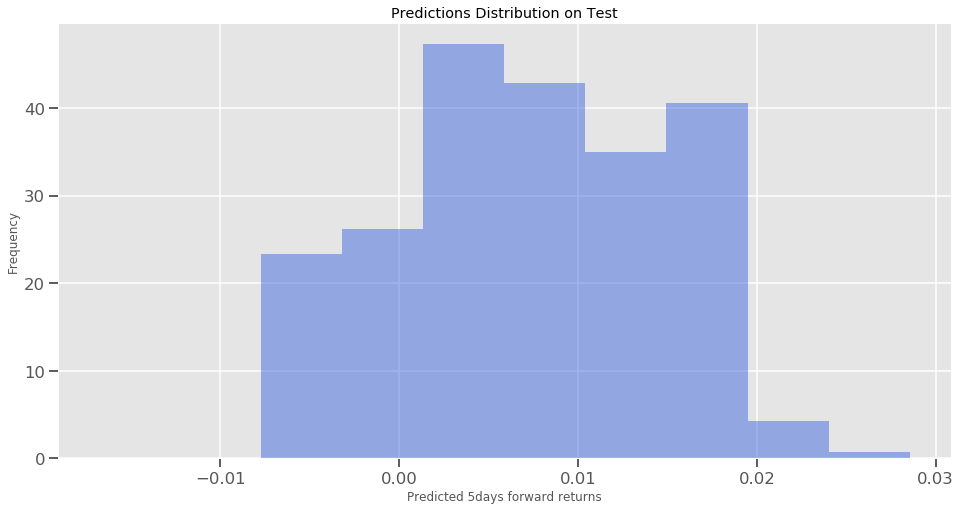

In [40]:
p_test_rf.plot.hist(color='royalblue', density=True, alpha=0.5)
plt.title('Predictions Distribution on Test')
plt.xlabel('Predicted 5days forward returns')
plt.show()

## Factor Returns

In [41]:
all_alphas = ['Mean_Reversion_Sector_Neutral_Smoothed', 'Momentum_1YR_Smoothed',
       'Overnight_Sentiment_Smoothed']

In [42]:
ml_alpha_test = mle_utils.get_pred_alpha(p_test_rf, kind='reg')
avg_combi_alpha_test = X_test_full[all_alphas].mean(axis=1)

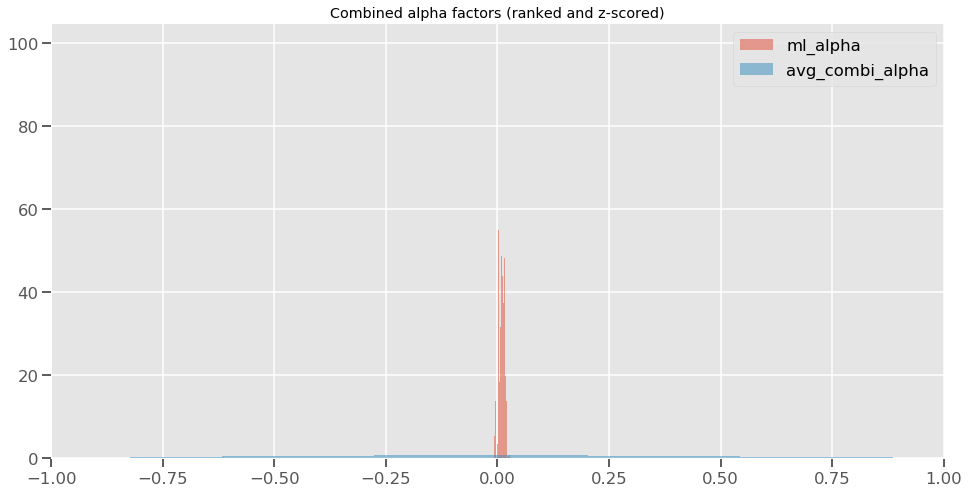

In [43]:
ml_alpha_test.hist(density=True, bins=50, alpha=0.5, label='ml_alpha')
avg_combi_alpha_test.hist(density=True, bins=50, alpha=0.5,  label='avg_combi_alpha')
plt.xlim(-1,1)
plt.legend()
plt.title("Combined alpha factors (ranked and z-scored)")
plt.show()

# Write Champion Model 

In [44]:
preds = p_test_rf.to_frame('p_test')
preds['ml_alpha'] = ml_alpha_test
preds['avg_combi_alpha'] = avg_combi_alpha_test
preds[all_alphas] = X_test_full[all_alphas] 

pd.concat([preds.head(2), preds.tail(2)], axis=0)

p_test  ml_alpha  avg_combi_alpha  \
date                      asset                                        
2015-05-26 00:00:00+00:00 A     -0.002769 -0.002769         0.483467   
                          AAL   -0.002696 -0.002696         1.197722   
2015-12-28 00:00:00+00:00 ZION   0.014175  0.014175         0.636962   
                          ZTS    0.011151  0.011151        -0.097619   

                                 Mean_Reversion_Sector_Neutral_Smoothed  \
date                      asset                                           
2015-05-26 00:00:00+00:00 A                                    1.534003   
                          AAL                                  1.692444   
2015-12-28 00:00:00+00:00 ZION                                 0.773366   
                          ZTS                                 -0.944433   

                                 Momentum_1YR_Smoothed  \
date                      asset                          
2015-05-26 00:00:00+00:00 A                  -1.233543   
                          AAL                 0.236520   
2015-12-28 00:00:00+00:00 ZION               -0.188031   
                          ZTS                 0.209727   

                                 Overnight_Sentiment_Smoothed  
date                      asset                                
2015-05-26 00:00:00+00:00 A                          1.149941  
                          AAL                        1.664201  
2015-12-28 00:00:00+00:00 ZION                       1.325552  
                          ZTS                        0.441851

In [45]:
preds.to_csv(OUTPATH + OUTFILE1)

In [46]:
with open(MODEL_PATH + MODEL_NAME, 'wb') as file:
    pickle.dump(champ_rf, file)

In [47]:
metadata = {
    'train_start_dt': train_dates[0].strftime('%Y-%m-%d'),
    'factor_start_dt': test_dates[0].strftime('%Y-%m-%d'),
    'factor_end_dt': test_dates[-1].strftime('%Y-%m-%d'),
    'model': 'RandomForest',
    'kind': 'static'}

In [48]:
with open(MODEL_PATH + MODEL_METADATA, 'wb') as file:
    pickle.dump(metadata, file)